In [655]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [656]:
def f(x):
    return 3*x**2 - 4*x + 5

In [657]:
f(3.0)

20.0

xs:
 [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
ys:
 [100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


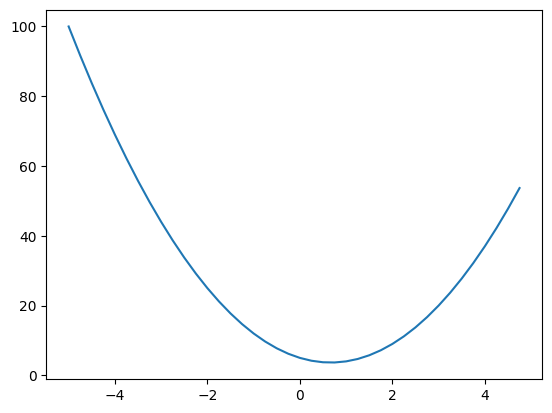

In [658]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(f'xs:\n {xs}')
print(f'ys:\n {ys}')
plt.plot(xs, ys)

In [659]:
h = 0.0000001
x = 2/3
(f(x+h) - f(x)) / h


2.9753977059954195e-07

In [660]:
# 进行更多计算

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [661]:
h = 0.0001

# 输入
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
c += h
d2 = a*b + c

print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"slope: {(d2-d1)/h}")



d1: 4.0
d2: 3.9997999999999987
slope: -2.0000000000131024


# forward 传播

In [662]:
# 未修复bug的版本, 在我们进行到 bug 修复之前, 我们先运行一下这个版本, 看看会发生什么
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [663]:
# 我们只需要在 def _backward() 中, 将 = 改为 += 即可

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [664]:
from graphviz import Digraph

def trace(root):
    # 建立图中所有节点和边的集合
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'}) # LR = 从左到右

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # 对于图中的任何值，为其创建一个矩形(“记录”)节点
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            # 如果该值是由操作创建的，则创建一个椭圆形节点
            dot.node(name=uid + n._op, label=n._op)
            # 创建一个从操作节点到值节点的边
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # 创建一个从n1到n2的边
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

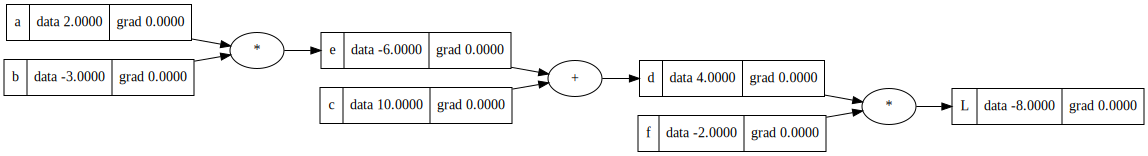

In [665]:
# 可视化 forward 转播

draw_dot(L)

# 手动 backword 传播

In [666]:
# L = d * f

# dL/dd =? f

# (f(x+h) - f(x)) / h

# ((d+h)*f - d*f) / h

# (d*f + h*f - d*f) / h

# (h*f) / h
# f

In [667]:
# f.grad = 4.0
# d.grad = -2.0

In [668]:
# dd / dc ? 1.0

# d = c + e

# (f(x+h) - f(x)) / h

# ((c + h + e )- (c - e ))/ h

# (c + h + e - c - e )/ h
# h / h
# 1.0

In [669]:
# c.grad = 1.0
# e.grad = 1.0

In [670]:
# dd / dc = 1.0
# dd / de = 1.0
# d = c + e

# WANT:
#     dL / bc = (dL / dd) * (dd / dc)

# KNOWN:
#     dL / dd
#     dd / dc

In [671]:
# a.grad = -2.0 * -3.0
# b.grad = -2.0 * 2.0

In [672]:
# dL / de = -2.0

# e = a * b
# de / da ? b

# dL / da = (dL / de) * (de / da)


In [673]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad


e = a * b
d = e + c
L = d * f


In [674]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')

    a.data += h

    b = Value(-3.0, label='b')

    b.data += h

    c = Value(10.0, label='c')

    # c.data += h

    e = a*b; e.label = 'e'

    c.data += h

    d = e + c; d.label = 'd'
    f = Value(-2.0 , label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

-0.001999999998503199


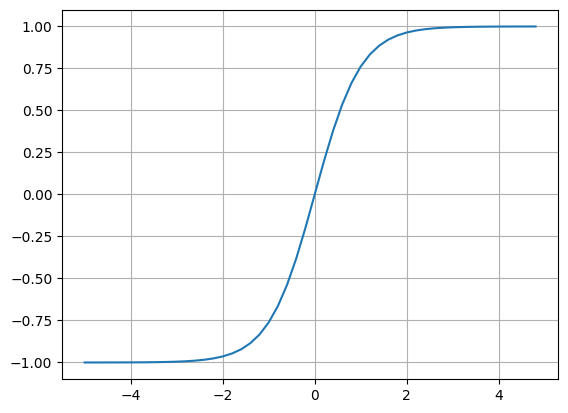

In [675]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid(); plt.show()

继续十分荒唐的手动 forward 传播

In [676]:
"""

grad : 梯度
weight : 权重
bias : 偏置
label : 标签

"""

# 输入 x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')


# 权重 w1, w2

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')


# 偏置 b

b = Value(6.8813735870195432, label='b')


# x1w1 + x2w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

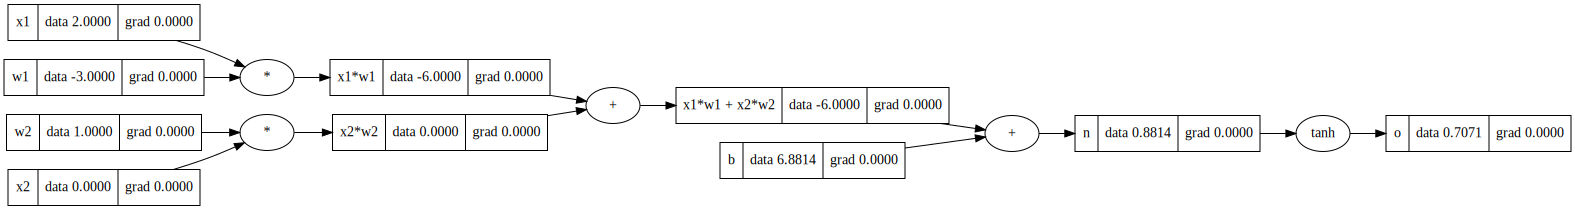

In [677]:
# 计算图
draw_dot(o)

继续十分荒唐的手动 backward 传播

In [678]:
# 1
o.grad = 1.0

In [679]:
# o = tanh(n)
# do/dn = 1 - o**2
print(o.data)
print(1 - o.data**2)

0.7071067811865476
0.4999999999999999


In [680]:
# 2
n.grad = 0.5

In [681]:
# 3
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [682]:
# 4
x1w1.grad = 0.5
x2w2.grad = 0.5

In [683]:
# 5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [684]:
# 6
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

在这里我们开始进行自动 backward 传播

In [685]:
"""
grad : 梯度
weight : 权重
bias : 偏置
label : 标签
"""
# 输入 x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# 权重 w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# 偏置 b
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

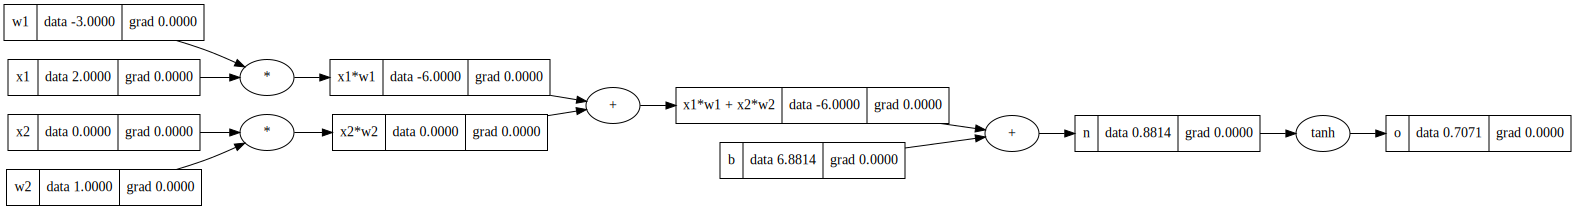

In [686]:
# 计算图
draw_dot(o)

In [687]:
# 1
o.grad = 1.0

In [688]:
# 2
o._backward()

In [689]:
# 3
n._backward()

In [690]:
# 4
b._backward()
x1w1x2w2._backward()

In [691]:
# 5
x2w2._backward()
x1w1._backward()

使用代码块进一步自动化 backward 传播

In [692]:
"""
grad : 梯度
weight : 权重
bias : 偏置
label : 标签
"""
# 输入 x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# 权重 w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# 偏置 b
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

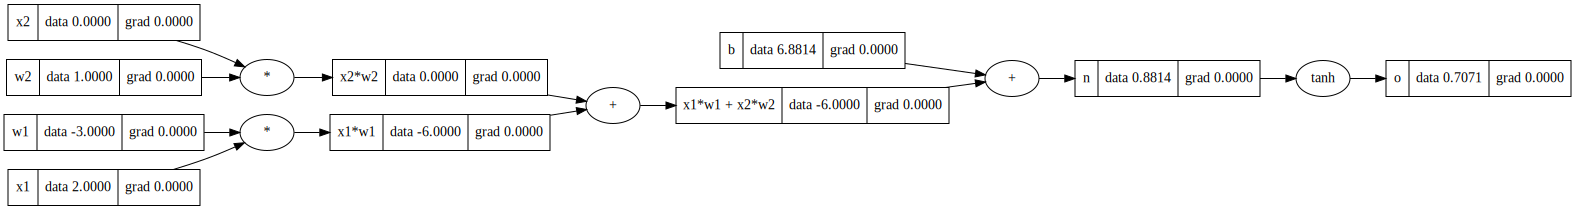

In [693]:
# 计算图
draw_dot(o)

In [694]:
# 完全自动化
o.backward()

In [695]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [696]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

一些bug

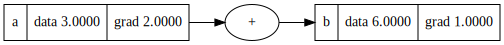

In [697]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

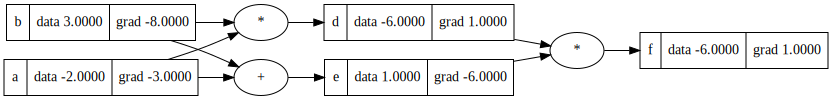

In [698]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b  ; d.label = 'd'
e = a + b  ; e.label = 'e'
f = d * e  ; f.label = 'f'

f.backward()

draw_dot(f)

看起来我们在之前每个变量只使用一次时,backward 传播是正确的.
<br>
但是一旦我们使用了多次,就会出现问题.
<br>
让我们参考链式法则,回到 class Value 中,进行修改.


经过前面的学习与调试, 我们进行一些清理, 使得代码更加简洁.

In [699]:

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "只有整数和浮点数可以作为指数"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    

    def __rmul__(self, other): # other * self
        return self * other
    

    def __truediv__(self, other): # self / other
        return self * other**-1
    

    def __neg__(self): # -self
        return self * -1
    

    def __sub__(self, other): # self - other
        return self + (-other)
    

    def __radd__(self, other): # other + self
        return self + other
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        
        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

我们来看看我们的代码是否能够处理更加复杂的情况.

In [700]:
a = Value(2)
# a + 2
# a * 2
# 2 * a
a.exp()

Value(data=7.38905609893065)

In [701]:
# a / b
# a * (1/b)
# a * (b**-1)

a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [702]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [703]:
from graphviz import Digraph

def trace(root):
    # 建立图中所有节点和边的集合
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'}) # LR = 从左到右

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # 对于图中的任何值，为其创建一个矩形(“记录”)节点
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            # 如果该值是由操作创建的，则创建一个椭圆形节点
            dot.node(name=uid + n._op, label=n._op)
            # 创建一个从操作节点到值节点的边
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # 创建一个从n1到n2的边
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [704]:
# 输入 x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# 权重 w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# 偏置 b
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

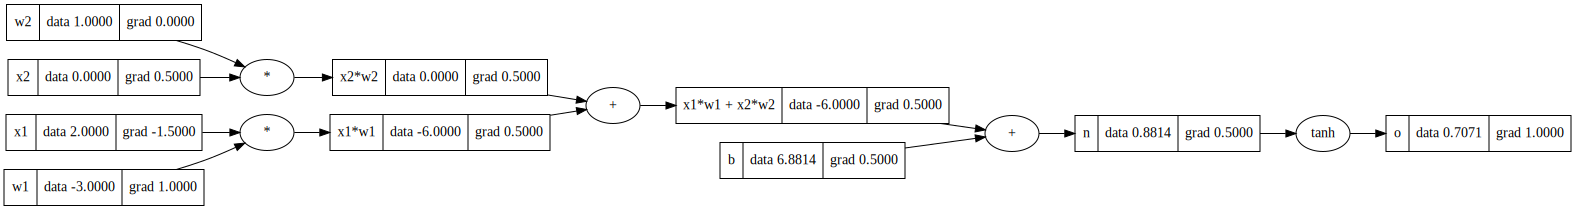

In [705]:
draw_dot(o)

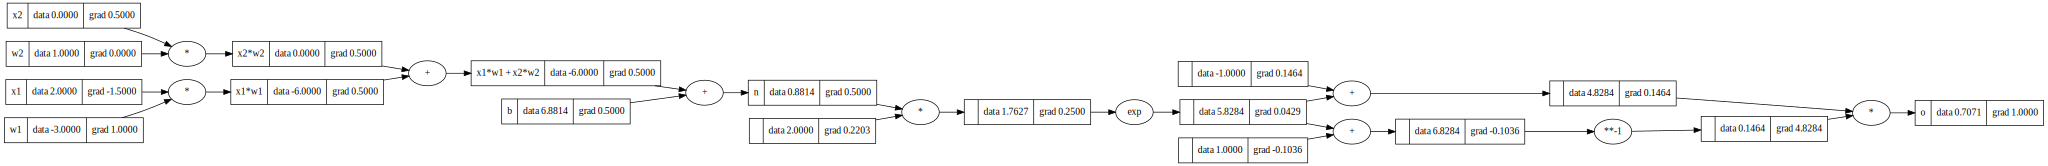

In [706]:
# 分割tenh函数

# 输入 x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# 权重 w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# 偏置 b
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ------------------------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------------------------------
o.label = 'o'
o.backward()
draw_dot(o)

#### 实际上Pytorch已经帮我们完成了这些基层的工作, 接下来我们开始学习如何使用Pytorch来完成这些工作.

In [707]:
import torch

In [708]:
x1 = torch.Tensor([2.0]).double()  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('------------------')
print(f"x2.grad = {x2.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")
print(f"x1.grad = {x1.grad.item()}")
print(f"w1.grad = {w1.grad.item()}")

0.7071066904050358
------------------
x2.grad = 0.5000001283844369
w2.grad = 0.0
x1.grad = -1.5000003851533106
w1.grad = 1.0000002567688737


In [722]:

class Neuron:
    """神经元"""
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    """层"""
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    """多层感知器"""
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

# x = [2.0, 3.0]
# n = Neuron(2)
# print(n(x), end='\n\n')

# x = [2.0, 3.0]
# l = Layer(2, 3)
# print(l(x), end='\n\n')

# x = [2.0, 3.0, -1.0]
# mlp = MLP(3, [4, 4, 1])
# mlp(x)

In [723]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6487836018970552)

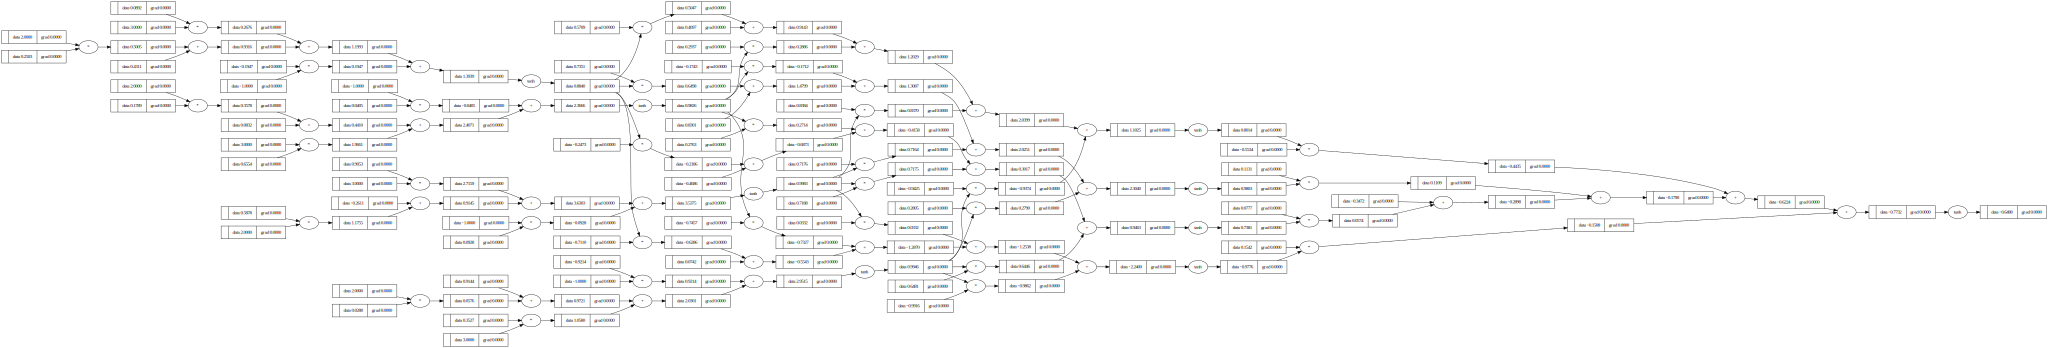

In [725]:
draw_dot(n(x))

In [809]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # 预期目标输出

In [806]:
ypred = [n(x) for x in xs] # 实际输出
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.745787954231002e-05)

In [805]:
# 3
ypred = [n(x) for x in xs] # 实际输出
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))


print(f"loss = {loss.data}")
for i in ypred:
    print(f"y = {i.data}")

loss = 3.745787954231002e-05
y = 0.9994165270789872
y = -0.9998386720816984
y = -0.9997423899298414
y = 0.9939151787826359


In [804]:
# 2
loss.backward()

In [803]:
# 1
for p in n.parameters():
    p.data += -0.01 * p.grad

接下来使用循环来完成这些 forward 传播与 backward 传播.

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # 预期目标输出

In [810]:
# 训练循环
for k in range(10):
    # forward 传播
    ypred = [n(x) for x in xs] # 实际输出
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward 传播
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # 更新参数
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(f"step = {k}, loss = {loss.data}")

ypred

step = 0, loss = 2.6435920350261033e-18
step = 1, loss = 2.6435920350261033e-18
step = 2, loss = 2.6435920350261033e-18
step = 3, loss = 2.6435920350261033e-18
step = 4, loss = 2.6435920350261033e-18
step = 5, loss = 2.6435920350261033e-18
step = 6, loss = 2.6435920350261033e-18
step = 7, loss = 2.6435920350261033e-18
step = 8, loss = 2.6435920350261033e-18
step = 9, loss = 2.6435920350261033e-18


[Value(data=0.99999999979214),
 Value(data=-0.9999999992814343),
 Value(data=-0.9999999985710663),
 Value(data=0.9999999997945784)]